In [ ]:
!pip install gensim
!pip install keras


In [3]:
import pandas as pd
import io
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



In [4]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [5]:
# Word2vec
import gensim

In [6]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [7]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# DATASET
DATASET_COLUMNS = ["date_posted", "hour_played", "recommendation", "text", "title", "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 6
BATCH_SIZE = 1024

# SENTIMENT
RECOMMENDED = "RECOMMENDED"
NOT_RECOMMENDED = "NOT RECOMMENDED"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# READ DATA SET

In [10]:
from google.colab import files
uploaded = files.upload()

Saving clean_steam_reviews.csv to clean_steam_reviews (1).csv


In [11]:
steam_df = pd.read_csv(io.BytesIO(uploaded['clean_steam_reviews.csv']))
steam_df.head()

,Unnamed: 0,date_posted,hour_played,recommendation,text,title,target
0,0,2019-02-10,578,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,1
1,1,2019-02-10,184,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,1
2,2,2019-02-07,892,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,1
3,3,2018-06-14,676,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1
4,4,2017-06-20,612,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1


In [ ]:
#Read in the clean_steam_reviews CSV
# steam_df = pd.read_csv(os.path.join("clean_steam_reviews.csv"))
# steam_df.head(10)

# steam_df = pd.read_csv(io.StringIO(uploaded['clean_steam_reviews.csv'].decode('utf-8')))
# steam_df.head(10)

In [ ]:
# dataset_filename = os.listdir("clean_steam_reviews")[0]
# dataset_path = os.path.join("input",dataset_filename)
# print("Open file:", dataset_path)
# df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [12]:
print("Dataset size:", len(steam_df))

Dataset size: 433375


In [13]:
steam_df.head(5)

,Unnamed: 0,date_posted,hour_played,recommendation,text,title,target
0,0,2019-02-10,578,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,1
1,1,2019-02-10,184,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,1
2,2,2019-02-07,892,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,1
3,3,2018-06-14,676,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1
4,4,2017-06-20,612,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1


# Map Target Label to String

In [14]:
decode_map = {0: "NOT RECOMMENDED", 1: "RECOMMENDED"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [15]:
%%time
steam_df.target = steam_df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 139 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

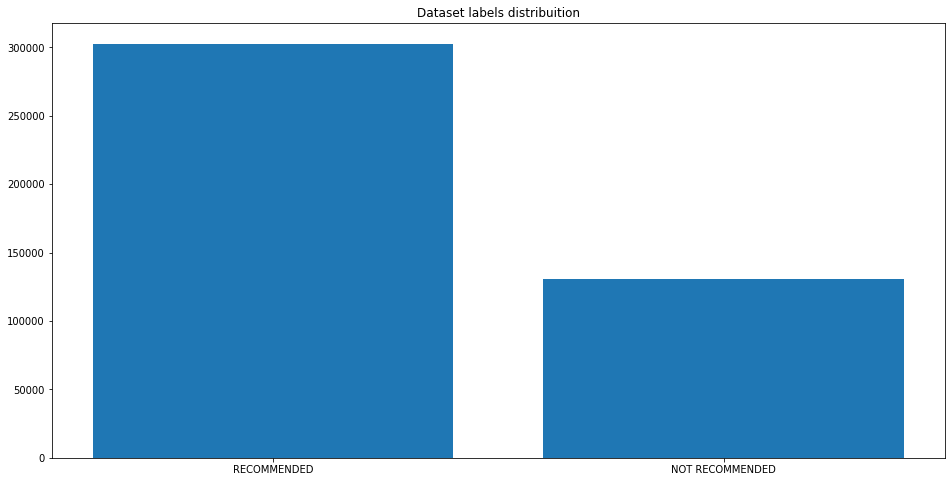

In [16]:
target_cnt = Counter(steam_df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

# Pre Process Data Set

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
stoplist = set(stopwords.words("english"))
stoplist.remove("not")

In [19]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

# Split and Train Test

In [20]:
df_train, df_test = train_test_split(steam_df, test_size=1-TRAIN_SIZE, random_state=50)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 346700
TEST size: 86675


In [21]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.03 s, sys: 395 ms, total: 2.42 s
Wall time: 2.42 s


# Word2Vec

In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.45 s, sys: 453 ms, total: 2.91 s
Wall time: 2.91 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=6)

In [24]:
w2v_model.build_vocab(documents)

2021-03-13 21:05:11,873 : INFO : collecting all words and their counts
2021-03-13 21:05:11,876 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-13 21:05:11,952 : INFO : PROGRESS: at sentence #10000, processed 409048 words, keeping 37138 word types
2021-03-13 21:05:12,026 : INFO : PROGRESS: at sentence #20000, processed 816953 words, keeping 59490 word types
2021-03-13 21:05:12,111 : INFO : PROGRESS: at sentence #30000, processed 1223397 words, keeping 79233 word types
2021-03-13 21:05:12,187 : INFO : PROGRESS: at sentence #40000, processed 1623652 words, keeping 96975 word types
2021-03-13 21:05:12,278 : INFO : PROGRESS: at sentence #50000, processed 2036715 words, keeping 114105 word types
2021-03-13 21:05:12,352 : INFO : PROGRESS: at sentence #60000, processed 2433827 words, keeping 129383 word types
2021-03-13 21:05:12,432 : INFO : PROGRESS: at sentence #70000, processed 2834735 words, keeping 143938 word types
2021-03-13 21:05:12,511 : INFO : PROGR

In [25]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 31485


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-03-13 21:05:32,887 : INFO : training model with 6 workers on 31485 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-03-13 21:05:33,922 : INFO : EPOCH 1 - PROGRESS: at 3.95% examples, 399220 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:34,954 : INFO : EPOCH 1 - PROGRESS: at 8.14% examples, 412452 words/s, in_qsize 12, out_qsize 2
2021-03-13 21:05:35,951 : INFO : EPOCH 1 - PROGRESS: at 12.33% examples, 419621 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:36,963 : INFO : EPOCH 1 - PROGRESS: at 16.41% examples, 418851 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:37,973 : INFO : EPOCH 1 - PROGRESS: at 20.74% examples, 421613 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:38,974 : INFO : EPOCH 1 - PROGRESS: at 25.14% examples, 426966 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:39,976 : INFO : EPOCH 1 - PROGRESS: at 29.28% examples, 425479 words/s, in_qsize 11, out_qsize 0
2021-03-13 21:05:40,979 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 24min 47s, sys: 6.72 s, total: 24min 54s
Wall time: 12min 43s


(331577049, 449907264)

In [27]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-03-13 21:29:21,368 : INFO : precomputing L2-norms of word weight vectors


[('hate', 0.6941418051719666),
 ('Love', 0.6532096862792969),
 ('loved', 0.6502095460891724),
 ('enjoy', 0.6480669379234314),
 ('adore', 0.6168540716171265),
 ('liked', 0.5942255258560181),
 ('LOVE', 0.5731377601623535),
 ('dislike', 0.5296758413314819),
 ('luv', 0.5292836427688599),
 ('enjoyed', 0.4925728440284729)]

In [28]:
w2v_model.most_similar("fun")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fun.', 0.7215197086334229),
 ('enjoyable', 0.7023166418075562),
 ('fun!', 0.6535427570343018),
 ('blast', 0.5873757004737854),
 ('funny', 0.5837901830673218),
 ('entertaining', 0.576908528804779),
 ('great', 0.5548355579376221),
 ('good', 0.5437201261520386),
 ('boring', 0.528954267501831),
 ('fun...', 0.5275879502296448)]

In [29]:
w2v_model.most_similar("exciting")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('entertaining', 0.6656864881515503),
 ('intense', 0.660645067691803),
 ('interesting', 0.6270351409912109),
 ('thrilling', 0.6258715391159058),
 ('tense', 0.6205111145973206),
 ('enjoyable', 0.6112058162689209),
 ('engaging', 0.5913442969322205),
 ('challenging', 0.5809884667396545),
 ('addictive', 0.560731053352356),
 ('immersive', 0.5580490827560425)]

In [30]:
w2v_model.most_similar("sucks")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sucks.', 0.6206700801849365),
 ('suck', 0.48802563548088074),
 ('sux', 0.48747187852859497),
 ('hurts', 0.4376883804798126),
 ('ruins', 0.4221021831035614),
 ('sucks...', 0.4079853892326355),
 ('suck.', 0.37858861684799194),
 ('Sucks', 0.36644458770751953),
 ('hate', 0.36272937059402466),
 ('lags', 0.359108030796051)]

In [31]:
w2v_model.most_similar("hate")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('love', 0.6941418051719666),
 ('dislike', 0.6425459384918213),
 ('despise', 0.5355886220932007),
 ('hated', 0.5269489288330078),
 ('suck', 0.4887895882129669),
 ('enjoy', 0.48662248253822327),
 ('HATE', 0.4845544695854187),
 ('hates', 0.45592963695526123),
 ('liked', 0.4444247782230377),
 ('loved', 0.4357396364212036)]

# Tokenize Text

In [32]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 196286
CPU times: user 10.1 s, sys: 46 ms, total: 10.1 s
Wall time: 10.1 s


In [33]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 12.1 s, sys: 178 ms, total: 12.3 s
Wall time: 12.3 s


# Label Encoder

In [35]:
labels = df_train.target.unique().tolist()
# labels.append(NEUTRAL)
labels

['RECOMMENDED', 'NOT RECOMMENDED']

In [36]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (346700, 1)
y_test (86675, 1)


In [37]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (346700, 300)
y_train (346700, 1)

x_test (86675, 300)
y_test (86675, 1)


In [38]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]])

# Embedding Layer

In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(196286, 300)


In [40]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-03-13 21:31:07,028 : WARNING : Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          58885800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 59,046,301
Trainable params: 160,501
Non-trainable params: 58,885,800
_________________________________________________________________


# Compile Model

In [47]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Callbacks

In [48]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# Train

In [49]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/6
305/305 [==============================] - 323s 1s/step - loss: 0.4594 - accuracy: 0.7712 - val_loss: 0.3317 - val_accuracy: 0.8609


2021-03-13 21:36:41,351 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/6
305/305 [==============================] - 312s 1s/step - loss: 0.3225 - accuracy: 0.8594 - val_loss: 0.3003 - val_accuracy: 0.8742


2021-03-13 21:41:53,363 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 3/6
305/305 [==============================] - 316s 1s/step - loss: 0.3045 - accuracy: 0.8675 - val_loss: 0.2942 - val_accuracy: 0.8798


2021-03-13 21:47:09,826 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 4/6
305/305 [==============================] - 310s 1s/step - loss: 0.2940 - accuracy: 0.8732 - val_loss: 0.2776 - val_accuracy: 0.8852


2021-03-13 21:52:19,739 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 5/6
305/305 [==============================] - 308s 1s/step - loss: 0.2836 - accuracy: 0.8779 - val_loss: 0.2749 - val_accuracy: 0.8858


2021-03-13 21:57:27,350 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 6/6
305/305 [==============================] - 305s 1000ms/step - loss: 0.2786 - accuracy: 0.8809 - val_loss: 0.2747 - val_accuracy: 0.8876


2021-03-13 22:02:32,236 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


CPU times: user 44min 14s, sys: 5min 56s, total: 50min 10s
Wall time: 31min 13s


# Evaluate

In [50]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

85/85 [==============================] - 14s 165ms/step - loss: 0.2765 - accuracy: 0.8866

ACCURACY: 0.8865993618965149
LOSS: 0.27653422951698303
CPU times: user 12.9 s, sys: 702 ms, total: 13.6 s
Wall time: 14.2 s


# Plot

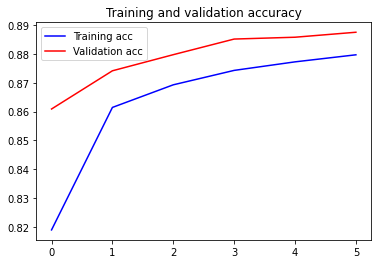

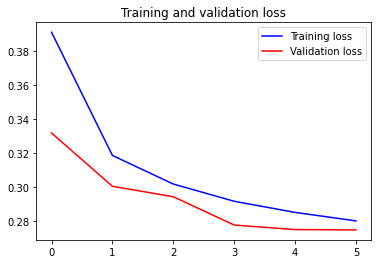

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(accuracy))
 
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Predict

In [52]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NOT_RECOMMENDED
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = RECOMMENDED

        return label
    else:
          return NOT_RECOMMENDED if score < 0.5 else RECOMMENDED

In [53]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [54]:
predict("I Love This!")

{'elapsed_time': 0.2920677661895752,
 'label': 'RECOMMENDED',
 'score': 0.9873477220535278}

In [55]:
predict("I REALLY hate this thing")

{'elapsed_time': 0.09389424324035645,
 'label': 'NEUTRAL',
 'score': 0.6032214760780334}

In [56]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.0924525260925293,
 'label': 'RECOMMENDED',
 'score': 0.8754724264144897}

In [57]:
predict("shit")

{'elapsed_time': 0.09369444847106934,
 'label': 'NOT RECOMMENDED',
 'score': 0.3145761489868164}

In [58]:
predict("this game sucks")

{'elapsed_time': 0.09343886375427246,
 'label': 'NOT RECOMMENDED',
 'score': 0.09722422808408737}

In [59]:
predict("Game released now so i'd thought it would be best if i edit my review.Vaulting is very solid and fun but the game developers have not fixed the real issue with the game.The Netcode Servers of PUBG are still running 15hz while good servers are supposed to run 65hz.The server performance is clearly noticable while playing the game you get shot after you get in cover. Damage takes a while to go into effect. Example I quickly peek another player and shoot him. He looks up but i duck into cover again. He shoots and a second after the shot i get hit in the head while i was in cover. This gunfight was CQB so there is no excuse for this slow bullettravel and hitbox issue.This game will not feel solid and after 200 hours the fun of winning doesn't feel like a reward. Its core issues arent being worked on or resolved so i don't see PUBG being a longtime favorite for most people")

{'elapsed_time': 0.09779882431030273,
 'label': 'NOT RECOMMENDED',
 'score': 0.28888794779777527}

In [60]:
predict("Currently the best Battle Royale out there")

{'elapsed_time': 0.09186816215515137,
 'label': 'RECOMMENDED',
 'score': 0.9983716607093811}

In [61]:
predict("I had fun and will play again")

{'elapsed_time': 0.09125804901123047,
 'label': 'RECOMMENDED',
 'score': 0.9669526219367981}

In [62]:
predict("I had fun but will not play again")

{'elapsed_time': 0.09398293495178223,
 'label': 'NEUTRAL',
 'score': 0.5833446383476257}

In [63]:
predict("I had a good time but there were issues online")

{'elapsed_time': 0.09386134147644043,
 'label': 'RECOMMENDED',
 'score': 0.9101329445838928}

In [64]:
predict("I did not have a good time, but the online was fun")

{'elapsed_time': 0.09176278114318848,
 'label': 'NEUTRAL',
 'score': 0.5600866079330444}

In [65]:
predict("This game fucking rocks!")

{'elapsed_time': 0.08821296691894531,
 'label': 'RECOMMENDED',
 'score': 0.9395471811294556}

In [66]:
predict("I had fun for a few hours, but I DO NOT recommend")

{'elapsed_time': 0.10816526412963867,
 'label': 'NOT RECOMMENDED',
 'score': 0.11143315583467484}

In [67]:
predict("Not enough Eddie, and not the Eddie we want. Murphy is just too generous in both these movies: he gives so much screen time away to his co-stars, he himself barely registers, yet he's the reason we're here.")

{'elapsed_time': 0.09848976135253906,
 'label': 'NEUTRAL',
 'score': 0.44562438130378723}

In [68]:
predict("Silly setup and plot. Real actors are painfully trying to interact with the cartoon cast.")

{'elapsed_time': 0.09300971031188965,
 'label': 'NEUTRAL',
 'score': 0.6961286067962646}

In [69]:
predict("Playing with friends is hard but time well spent")

{'elapsed_time': 0.09119677543640137,
 'label': 'RECOMMENDED',
 'score': 0.9879342317581177}

# Confusiuon Matrix

In [70]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

11/11 [==============================] - 13s 1s/step
CPU times: user 9.29 s, sys: 4.5 s, total: 13.8 s
Wall time: 13.3 s


In [71]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

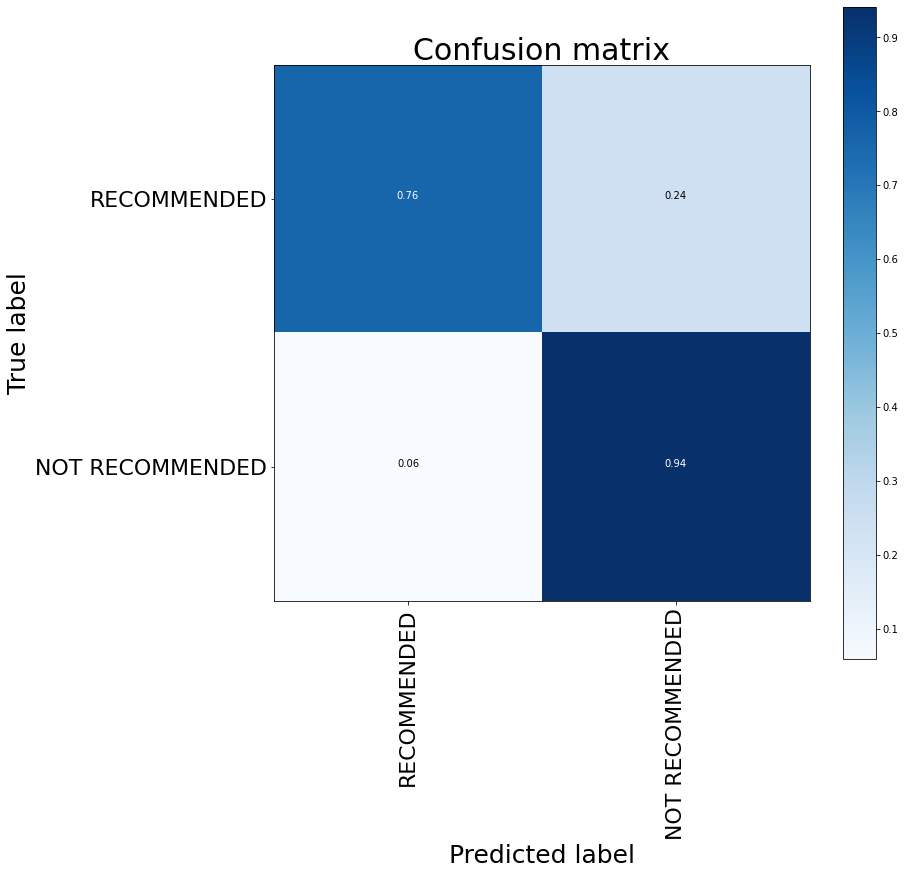

CPU times: user 539 ms, sys: 4.78 ms, total: 544 ms
Wall time: 551 ms


In [231]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

# Classification Report

In [72]:
print(classification_report(y_test_1d, y_pred_1d))

                 precision    recall  f1-score   support

NOT RECOMMENDED       0.85      0.75      0.80     26211
    RECOMMENDED       0.90      0.94      0.92     60464

       accuracy                           0.89     86675
      macro avg       0.88      0.85      0.86     86675
   weighted avg       0.89      0.89      0.88     86675



# Accuracy Score

In [73]:
accuracy_score(y_test_1d, y_pred_1d)

0.8865993654456302

# Save Model

In [74]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-03-13 22:19:31,383 : INFO : saving Word2Vec object under model.w2v, separately None
2021-03-13 22:19:31,385 : INFO : not storing attribute vectors_norm
2021-03-13 22:19:31,388 : INFO : not storing attribute cum_table
2021-03-13 22:19:32,181 : INFO : saved model.w2v
